# <font style = "color:rgb(50,120,229)">Skin Smoothing</font>

In previous modules we have seen how we can use grabcut for detecting skin region given the image of a face. The detected skin can then be smoothened and applied back to the original image, thereby resulting in a skin smoothened image. 

In this project, you will be implementing **Skin Smoothing** but this time the image will contain regions other than face as well and will have to be completely automated.

You can use the following steps to approach this problem:

1. Detect the faces in the image using Deep Learning or HAAR Cascades
2. Iterate over the detected faces and apply smoothing filter. You can experiment with the filter type and size to see which one (or combination) gives the best result.

In [449]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [450]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [451]:
# Read image
image_orig = cv2.imread(DATA_PATH + "images/hillary_clinton.jpg")
#image_orig = cv2.imread(DATA_PATH + "images/seniors.jpg")

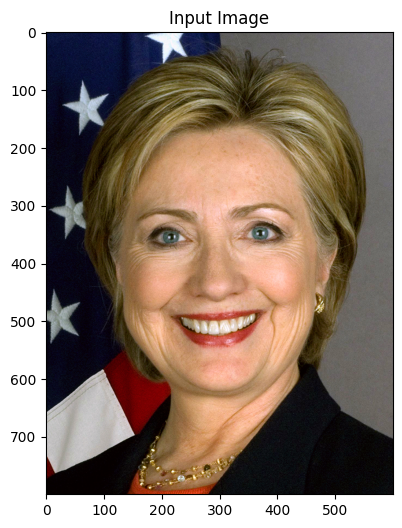

In [452]:
plt.imshow(image_orig[:,:,::-1])
plt.title("Input Image")
plt.show()

In [453]:
###
### YOUR CODE HERE
###
# Check OpenCV version
assert cv2.__version__ >= "4.9.0", \
       "Please install latest opencv-python to try this demo: python3 -m pip install --upgrade opencv-python"

In [454]:
###
### YOUR CODE HERE
###


def import_face_model(modelPath, config):
    """ 
    Inistatiate YuNet model with provided parameter. 
    https://github.com/opencv/opencv_zoo/blob/main/models/face_detection_yunet/demo.py
    """
    from yunet import YuNet

    backend_id = cv2.dnn.DNN_BACKEND_OPENCV
    target_id = cv2.dnn.DNN_TARGET_CPU

    modelPath = "./face_detection_yunet_2023mar.onnx"

    size = config['size']                      # input image side in pixels
    conf_threshold = config['conf_threshold']  # minimum needed confidence for the model to identify a face 
    nms_threshold = config['nms_threshold']    # Suppress bounding boxes of iou >= nms_threshold 
    top_k = config['top_k']                    # Keep top_k bounding boxes before NMS

    model = YuNet(modelPath=modelPath,
                  inputSize=[size, size],
                  confThreshold=conf_threshold,
                  nmsThreshold=nms_threshold,
                  topK=top_k,
                  backendId=backend_id,
                  targetId=target_id)
    
    return model

In [455]:
###
### YOUR CODE HERE
###


def extract_skin_patches(image, results):
    """ Crop face image and define skin color patches"""
 
    output = image.copy()
    cropped = []

    # process each detected face
    for det in results:

        # draw bounding box
        bbox = det[0:4].astype(np.int32)
        x,y,w,h = bbox
        cv2.rectangle(output, (x, y), (x+w, y+h), [0,255,0], 2)

        # draw face landmarks 
        landmarks = det[4:14].astype(np.int32).reshape((5,2))
        for i in range(landmarks.shape[0]):
            cv2.circle(output, landmarks[i], 10, [0,255,255], -1)
            cv2.putText(output, str(i), landmarks[i]-10, cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,0), 2, cv2.LINE_AA);

        # find forehead point 
        eye_l = landmarks[0]
        eye_r = landmarks[1]
        eye_vec = eye_r - eye_l
        eye_dist = (eye_vec[0]**2 + eye_vec[1]**2) ** 0.5
        eye_angle = np.arctan((eye_vec[1]*0.5) / (eye_vec[0]*0.5))  
        eye_mid = (eye_r + eye_l)/2
        R = np.array([[np.cos(eye_angle), -np.sin(eye_angle)], 
                      [np.sin(eye_angle), np.cos(eye_angle)]])
        forehead_vec = R @ np.array([0,-eye_dist*0.5])
        forehead = eye_mid  + forehead_vec  

        # find cheek points
        mouth_l = landmarks[3]
        mouth_r = landmarks[4]
        cheek_l = (mouth_l + eye_l)/2
        cheek_r = (mouth_r + eye_r)/2
        
        
        # draw skin patch locations
        cv2.circle(output, np.int64(forehead), 10, [0,0,255], -1)
        cv2.circle(output, np.int64(cheek_l), 10, [0,0,255], -1)
        cv2.circle(output, np.int64(cheek_r), 10, [0,0,255], -1)

        # extract_skin_patches
        patch_locations = [forehead, cheek_l, cheek_r]
        color_patches = [image[int(x[1]), int(x[0])] for x in patch_locations]

        # save cropped image and patches
        cropped.append(dict(image = image[y:y+h, x:x+w], bbox = bbox, colors = color_patches))
        
    return cropped, output
    

1 faces detected.


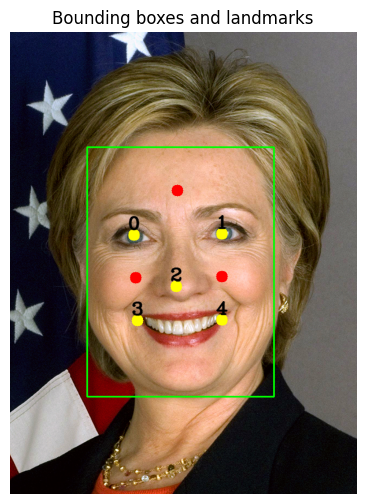

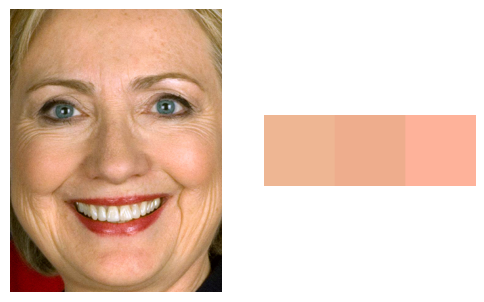

In [456]:
###
### YOUR CODE HERE
###


# ==================================================
# load face detector
modelPath="./face_detection_yunet_2023mar.onnx"
config = dict(size = 320, conf_threshold = 0.9, nms_threshold = 0.3, top_k = 5000 )
model = import_face_model(modelPath, config)

# ==================================================
# load image
image = image_orig.copy()

# ==================================================
# Inference (detect face)
h, w, _ = image.shape
model.setInputSize([w, h])
results = model.infer(image)

# ==================================================
# Visualize results and crop face images
print('{} faces detected.'.format(results.shape[0]))

cropped, output = extract_skin_patches(image, results)

plt.imshow(output[:,:,::-1])
plt.title("Bounding boxes and landmarks")
plt.axis('off')
plt.show()

fig = plt.figure(1)
for i, face in enumerate(cropped):
    # draw cropped face
    ax = fig.add_subplot(len(cropped),2,i*2+1)
    img = face['image']
    ax.imshow(img[:,:,::-1])
    ax.axis('off')
    
    # draw color patches
    ax = fig.add_subplot(len(cropped),2,i*2+2)
    patch = np.zeros((50,50*len(face['colors']),3), dtype = np.uint8)
    for c, color in enumerate(face['colors']):
        patch[:50,50*c:50*c+50] = color
    ax.imshow(patch[:,:,::-1])
    ax.axis('off')
plt.show()


In [457]:
###
### YOUR CODE HERE
###

def smooth_face(image, skin_colors, coverage: int = 30, radius = 7, verbose: bool = False):
    """ 
    Create skin mask then smooth skin under masked area 
    
    Parameters:
    ----------
    image (ndarray): face image to be smoothed in uint8 BGR format
    skin_colors (list[ndarray]): list of sin colors in uint8 BGR format
    coverage (int): HSV range for skin filter
    radius (int) : smoothing radius
    verbose (bool): should we show mask images ?
    """

    # convert to HSV
    image_hsv =  cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    colors_hsv = [cv2.cvtColor(x.reshape((1,1,3)), cv2.COLOR_BGR2HSV).ravel() for x in list(skin_colors)]
    
    # create mask
    mask = np.zeros(image.shape[:2]) 
    dH = coverage/2
    dS = coverage*2
    dV = coverage*2
    
    for col in colors_hsv:
        col_min = cv2.add(col, np.array([-dH,-dS,-dV]))
        col_max = cv2.add(col, np.array([+dH,+dS,+dV]))
        mask +=  cv2.inRange(image_hsv, col_min, col_max)
    mask = np.uint8(mask>0)*255
    mask = cv2.merge((mask,mask,mask))

    # blur image
    blurred = cv2.GaussianBlur(image,(radius,radius),0,0)
 
    
    # merge original and blurred image with mask
    not_changed = cv2.bitwise_and(image, cv2.bitwise_not(mask))
    smoothed = cv2.bitwise_and(blurred,mask)
    output = cv2.bitwise_or(not_changed, smoothed)

    
    
    
    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=3)
        ax[0].imshow(image[:,:,::-1])
        ax[1].imshow(mask)
        ax[2].imshow(output[:,:,::-1])
        ax[0].axis('off'), ax[1].axis('off'), ax[2].axis('off')
        plt.show()
        
        
    
    return output


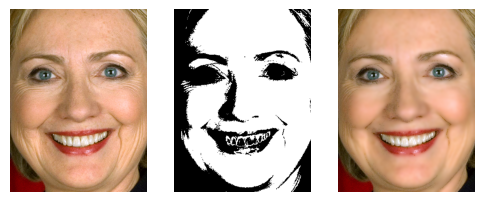

In [458]:
###
### YOUR CODE HERE
###

# ==================================
# smooth skin 

image_final = image_orig.copy()
for face in cropped:
    x,y,w,h = face['bbox']
    image_final[y:y+h, x:x+w] = smooth_face(face['image'], face['colors'],coverage = 30, radius=15, verbose=True)

# ==================================================
# place smoothed region on original image

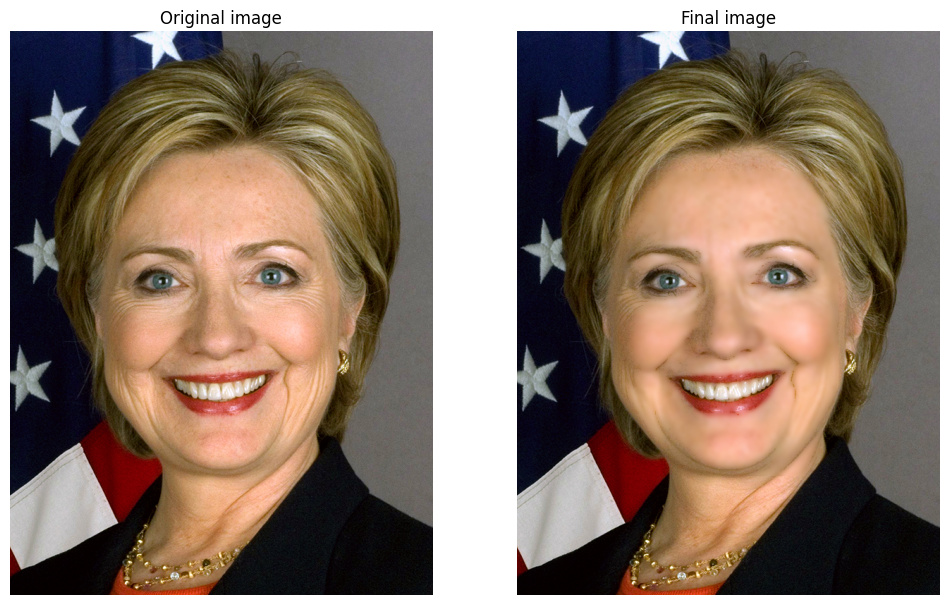

In [459]:
###
### YOUR CODE HERE
###

fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image_orig[:,:,::-1])
plt.axis('off')
plt.title("Original image")

ax1 = fig.add_subplot(1,2,2)
ax1.imshow(image_final[:,:,::-1])
plt.axis('off')
plt.title("Final image")

plt.show()